
# Support Vector Machine


## Initialization: courtesy of Tove

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import colorbar
from scipy.special import logit
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_selection import RFE, SequentialFeatureSelector  # RFE only works for linear SVM
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, cohen_kappa_score

from collections import Counter, defaultdict
#plt.style.use("seaborn-v0_8-colorblind")
# The following lets us import cleanup.py
# Specifically it adds SF295_G007 to the python system path

from cleanup import removeRows
from SVM.model import svm_model


In [4]:
data_processor = removeRows("../project_train.csv", rows_to_remove=[69, 85, 95])  # speechiness has an "outlier" as in one datapoint far away from the rest
data_processor.process_rows();
data = data_processor.df


Row 69 will be removed:
danceability          0.715
energy                0.288
key                   1.000
loudness            -13.843
mode                  1.000
speechiness           0.925
acousticness          0.785
instrumentalness      0.000
liveness              0.688
valence               0.772
tempo               115.114
Label                 0.000
Name: 68, dtype: float64

Row 85 will be removed:
danceability         0.4080
energy               0.7140
key                  0.0000
loudness            -6.9420
mode                 1.0000
speechiness          0.0666
acousticness         0.0356
instrumentalness     0.0000
liveness             0.2580
valence              0.7600
tempo               75.3970
Label                1.0000
Name: 85, dtype: float64

Row 95 will be removed:
danceability         0.8060
energy               0.6080
key                  1.0000
loudness            -7.0080
mode                 1.0000
speechiness          0.0659
acousticness         0.0113
instrum

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


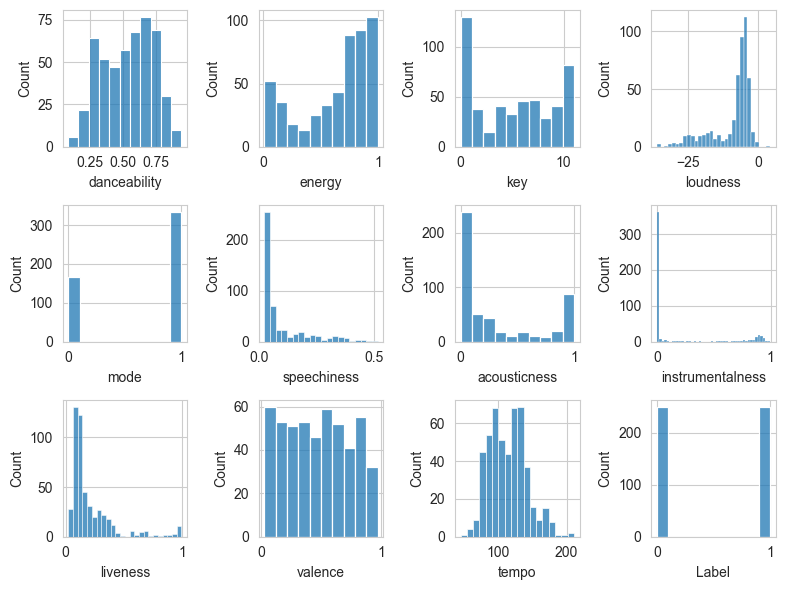

In [5]:
# Check distribution
fig, axes = plt.subplots(3, 4, figsize=(8, 6))
axes = axes.flatten()

for i, col in enumerate(data.columns):
    sns.histplot(data[col], kde=False, ax=axes[i])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.savefig('Distribution.eps', format='eps')
plt.show()

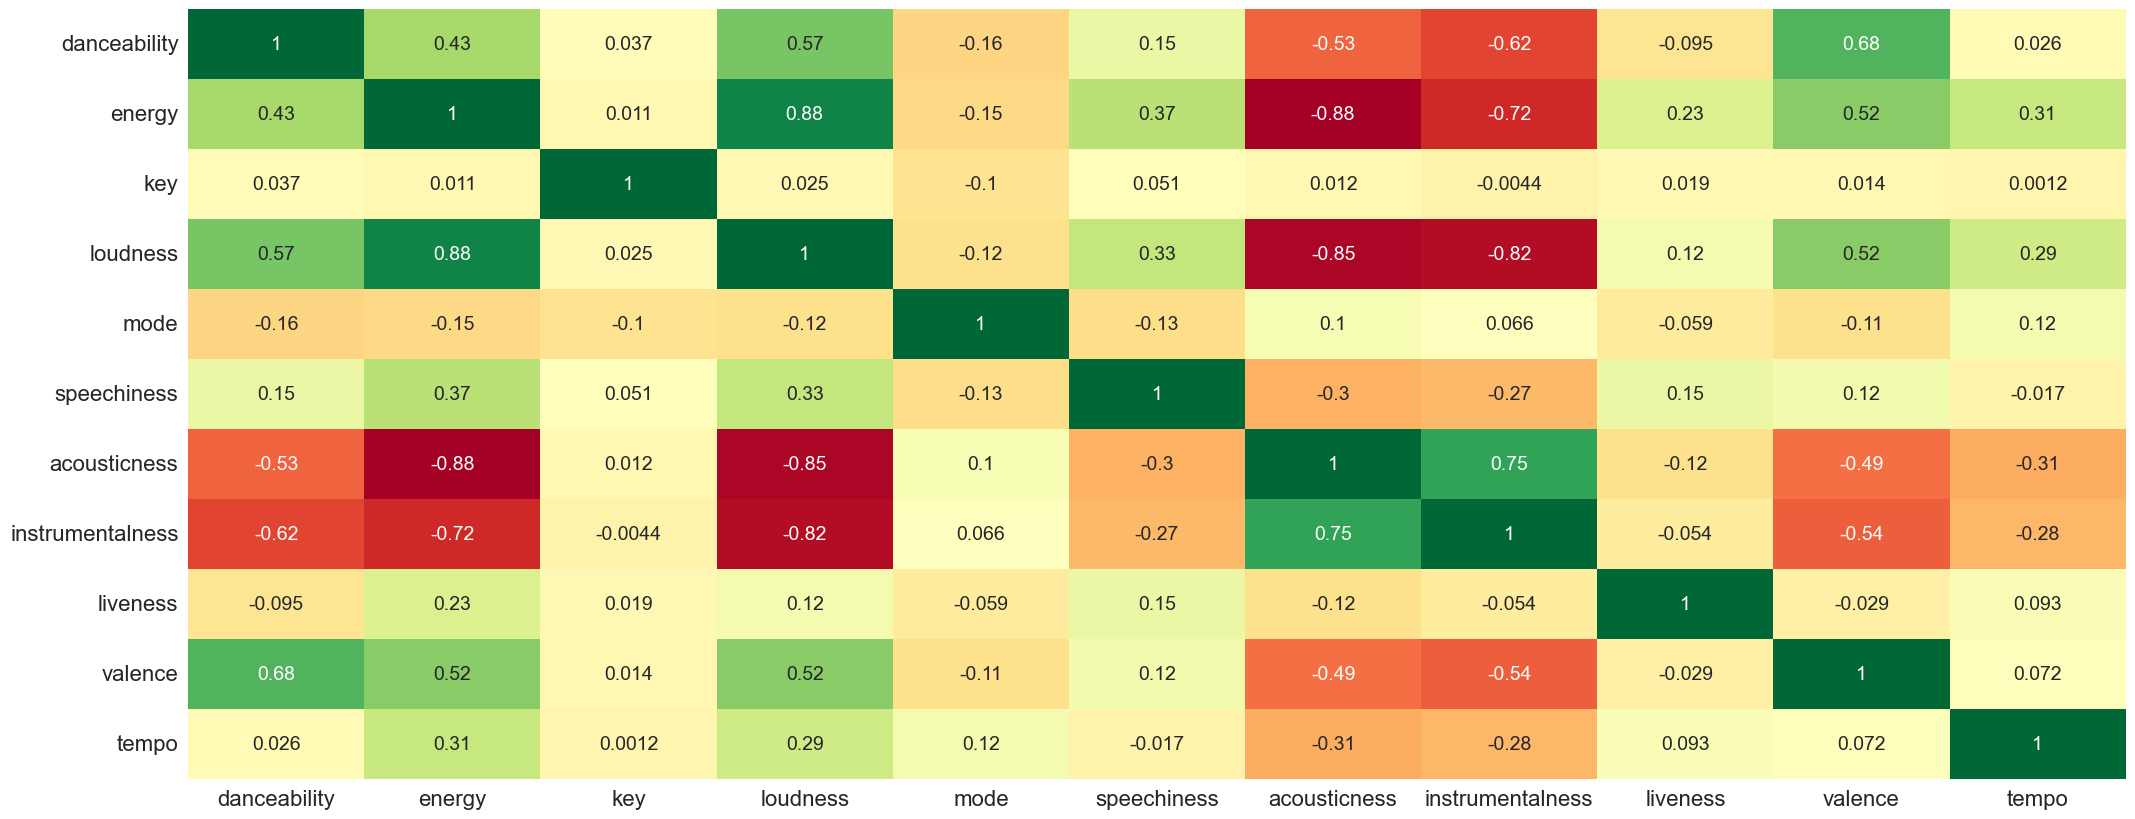

In [6]:
# heat map of correlation
features = data.drop([] + ["Label"], axis=1)
plt.figure(figsize=(25,10))
sns.heatmap(features.corr(), annot=True, cmap='RdYlGn', cbar=False, annot_kws={"size": 14})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('Correlation.eps', format='eps')

In [7]:
# Create the pairplot with scatter plots for off-diagonal and probability distributions (KDE) on diagonal
#sns.pairplot(data, hue = "Label", diag_kws={'fill': False}, corner=True)

## Transforming data - courtesy of Tove

In [8]:
vars_to_transform = [
    "danceability",
    "energy",
    "speechiness",
    "acousticness",
    "liveness",
    "valence",
]

transformed_data = data.copy()
transformed_data[vars_to_transform] = transformed_data[vars_to_transform].transform(logit)

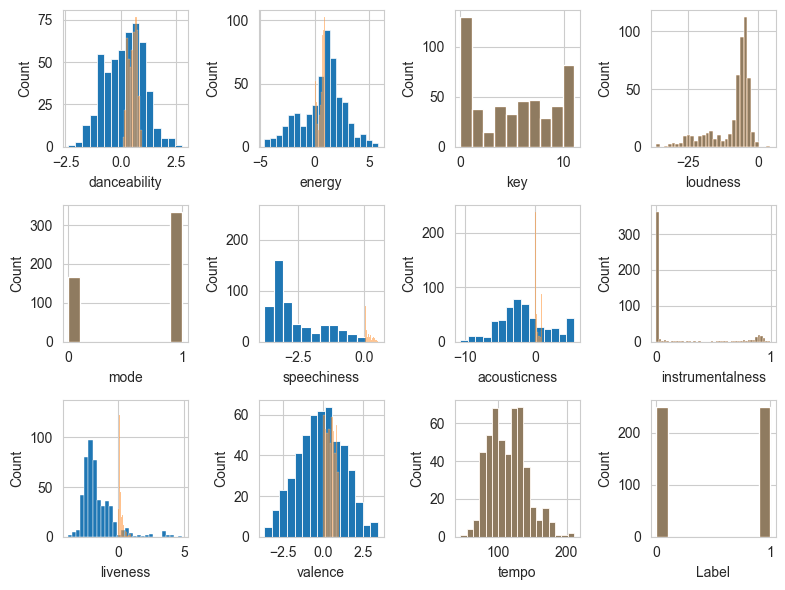

In [9]:
# Check distribution again, comparing transformed (blue) with initial (orange)
fig, axes = plt.subplots(3, 4, figsize=(8, 6))
axes = axes.flatten()

for i, col in enumerate(data.columns):
    sns.histplot(transformed_data[col], ax=axes[i],alpha=1)
    sns.histplot(data[col], ax=axes[i], alpha=0.5)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [10]:
#sns.pairplot(transformed_data[vars_to_transform + ["Label"]], hue = "Label", diag_kws={'fill': False})

In [11]:
scaled_data = transformed_data.copy()
scaled_data[vars_to_transform + ["loudness", "tempo"]] = preprocessing.scale(
    scaled_data[vars_to_transform + ["loudness", "tempo"]]
)
#sns.pairplot(scaled_data[vars_to_transform + ["loudness", "tempo", "Label"]], hue = "Label", diag_kws={'fill': False})

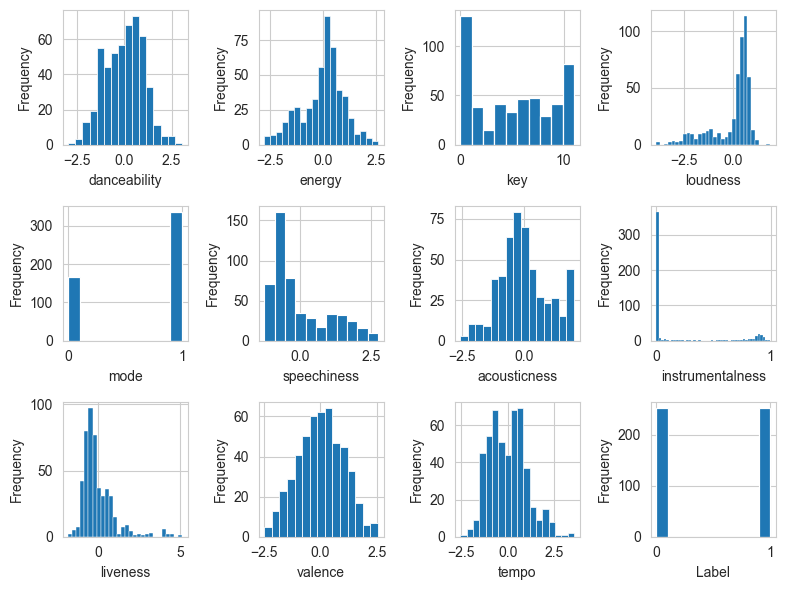

In [12]:
# Check distribution again, comparing scaled (blue) with transformed (orange)
fig, axes = plt.subplots(3, 4, figsize=(8, 6))
axes = axes.flatten()

for i, col in enumerate(scaled_data.columns):
    sns.histplot(scaled_data[col], ax=axes[i],alpha=1)
    #sns.histplot(transformed_data[col], ax=axes[i], alpha=0.5)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [13]:
all_predictors = scaled_data.drop([] + ["Label"], axis=1)
response = scaled_data["Label"]

# We drop_first because one of the variables in each of key,
# mode is determined by the values of the others
# (for example mode != 0 implies mode = 1)
encoded_data = pd.get_dummies(
    all_predictors, columns=["key", "mode"], drop_first=True
)

predictors_train, predictors_test, response_train, response_test = train_test_split(encoded_data, response, test_size=0.3, random_state=8)

<Axes: >

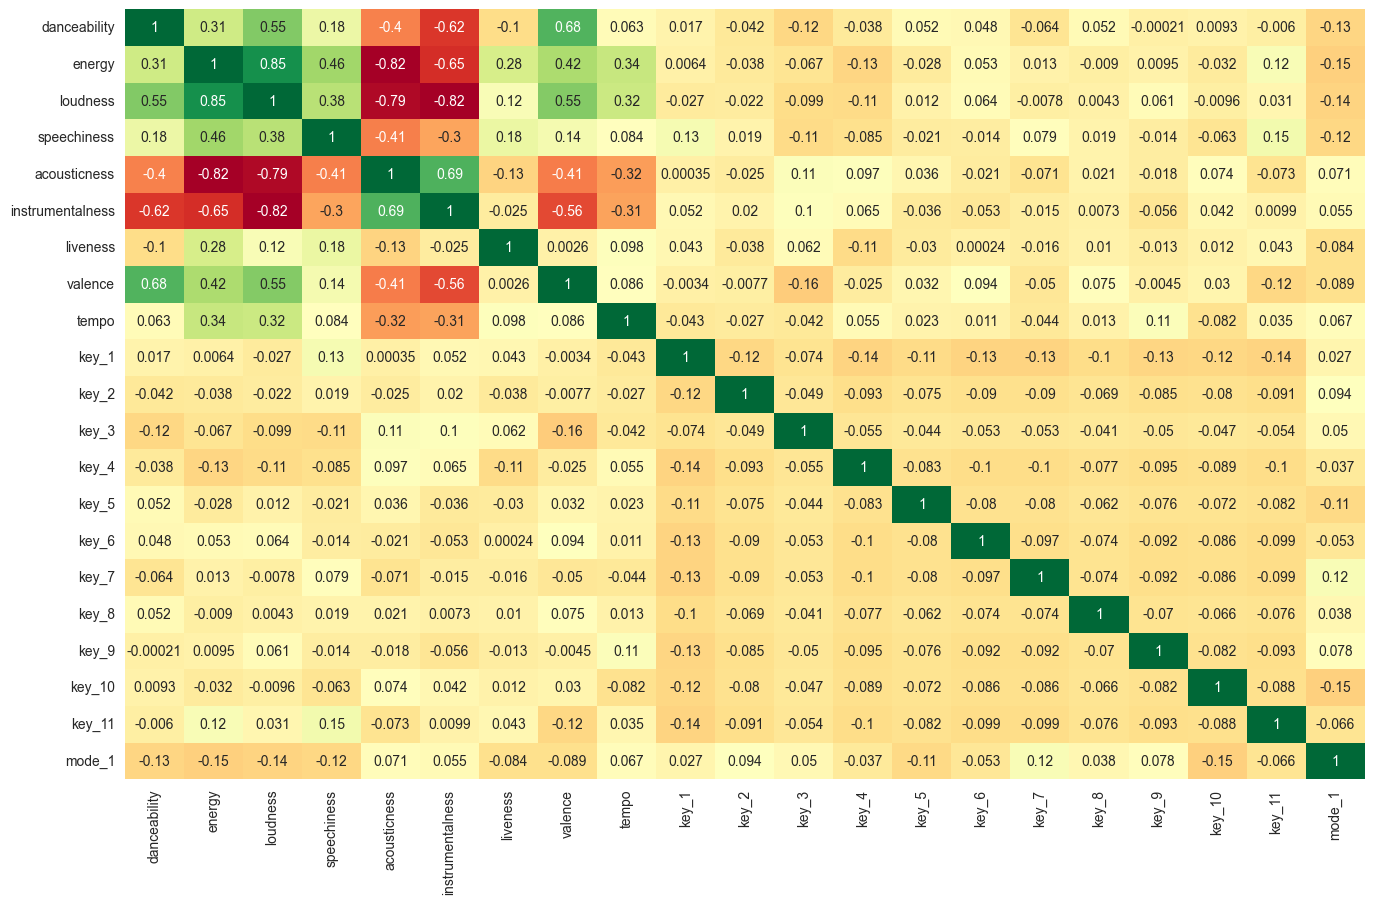

In [14]:
# heat map of correlation
plt.figure(figsize=(16,10))
sns.heatmap(predictors_train.corr(), annot=True, cmap='RdYlGn', cbar=False)

Loudness, acousticness, instrumentalness are probably redundant.

<Axes: >

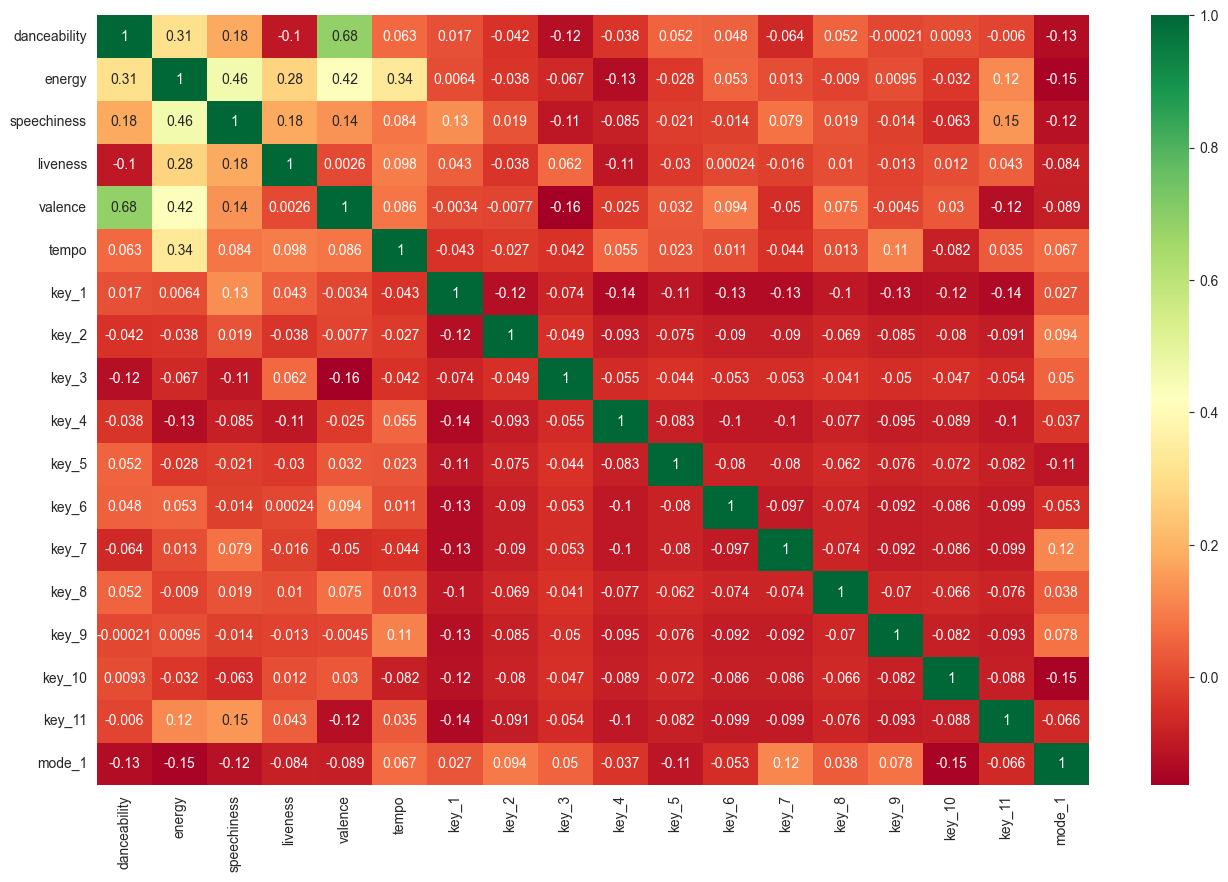

In [15]:
exclude = ['loudness', 'acousticness', 'instrumentalness']
predictors_train_mod = predictors_train.drop(columns=exclude)
plt.figure(figsize=(16, 10))
sns.heatmap(predictors_train_mod.corr(), annot=True, cmap='RdYlGn')

We can see valence is somewhat correlated to danceability, but the rest looks good to me.

In [16]:
predictors_train_mod, predictors_test_mod, response_train_mod, response_test_mod = train_test_split(encoded_data.drop(columns=exclude), response, test_size=0.3, random_state=8)

## Training the SVM
First, a linear SVM is tried

Accuracy: 81.46%
Precision: 83.82%
Recall: 77.03%
Cohen's Kappa Score: 0.63


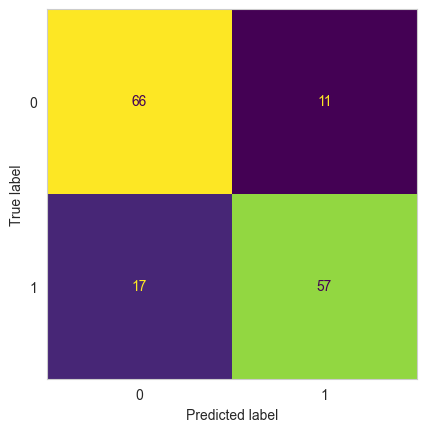

In [17]:
model, _ = svm_model('linear', predictors_train, response_train, predictors_test, response_test) 

ConfusionMatrixDisplay.from_estimator(model, predictors_test, response_test, colorbar=False, cmap='viridis')
plt.grid(False)

Accuracy: 81.46%
Precision: 85.94%
Recall: 74.32%
Cohen's Kappa Score: 0.63


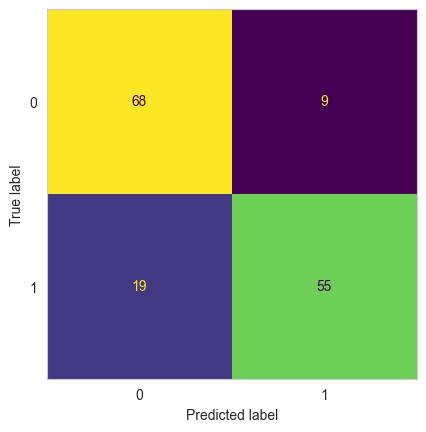

In [18]:
model, _ = svm_model('linear', predictors_train_mod, response_train_mod, predictors_test_mod, response_test_mod) 

ConfusionMatrixDisplay.from_estimator(model, predictors_test_mod, response_test_mod, colorbar=False, cmap='viridis')
plt.grid(False)

#### Now, a non-linear SVM with rbf (radial basis function) kernel:

Accuracy: 85.43%
Precision: 88.24%
Recall: 81.08%
Cohen's Kappa Score: 0.71


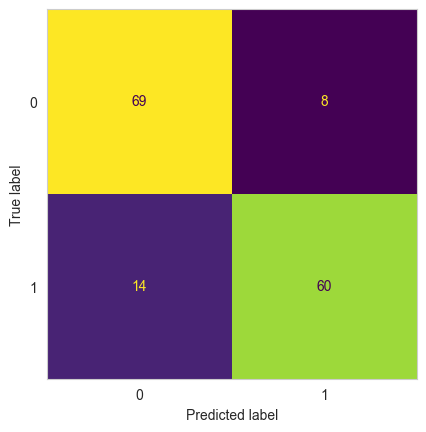

In [19]:
model, _ = svm_model('rbf', predictors_train, response_train, predictors_test, response_test) 

ConfusionMatrixDisplay.from_estimator(model, predictors_test, response_test, colorbar=False, cmap='viridis')
plt.grid(False)

Accuracy: 86.09%
Precision: 88.41%
Recall: 82.43%
Cohen's Kappa Score: 0.72


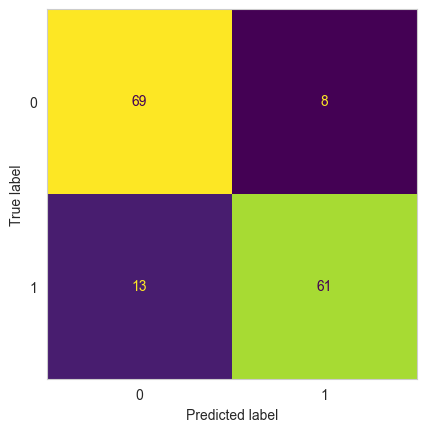

In [20]:
model, _ = svm_model('rbf', predictors_train_mod, response_train_mod, predictors_test_mod, response_test_mod) 

ConfusionMatrixDisplay.from_estimator(model, predictors_test_mod, response_test_mod, colorbar=False, cmap='viridis')
plt.grid(False)

### <span style="color:red">Depending on randomization seed, the results show improvement in accuracy and kappa score for the non-linear SVM compared to linear.</span>

## An attempt at feature optimization 

In [21]:
# # Forward sequential
# accuracies = {}
# features = {}
# for i in range(1, predictors_train.shape[1]):
#     sfs = SequentialFeatureSelector(estimator=SVC(kernel='rbf'), n_features_to_select=i)  # Forward selection process
#     sfs.fit(predictors_train, response_train)
#     
#     selected_features = sfs.get_support()  # Boolean mask of selected features    
#     predictors_train_sfs = predictors_train.loc[:, selected_features]
#     predictors_test_sfs = predictors_test.loc[:, selected_features]
#     
#     # Train again with the reduced feature set
#     model, accuracy = svm_model('rbf', predictors_train_sfs, response_train, predictors_test_sfs, response_test, metrics = 'sfs', i = i) 
#     
#     accuracies[i] = accuracy
#     features[i] = predictors_train_sfs.columns
# 
# print(f"The best accuracy is {accuracies[max(accuracies, key=accuracies.get)]} with {max(accuracies, key=accuracies.get)} features.")
# print(f'The selected features are {features[max(accuracies, key=accuracies.get)]}')


In [22]:
# # Backward sequential
# accuracies = {}
# features = {}
# for i in range(1, predictors_train.shape[1]):
#     sfs = SequentialFeatureSelector(estimator=SVC(kernel='rbf'), n_features_to_select=i, direction='backward')  # Forward selection process
#     sfs.fit(predictors_train, response_train)
#     
#     selected_features = sfs.get_support()  # Boolean mask of selected features    
#     predictors_train_sfs = predictors_train.loc[:, selected_features]
#     predictors_test_sfs = predictors_test.loc[:, selected_features]
#     
#     # Train again with the reduced feature set
#     model, accuracy = svm_model('rbf', predictors_train_sfs, response_train, predictors_test_sfs, response_test, metrics = 'sfs', i = i) 
#     
#     accuracies[i] = accuracy
#     features[i] = predictors_train_sfs.columns
# 
# print(f"The best accuracy is {accuracies[max(accuracies, key=accuracies.get)]} with {max(accuracies, key=accuracies.get)} features.")
# print(f'The selected features are {features[max(accuracies, key=accuracies.get)]}')

In [23]:
# # Forward sequential (modified)
# accuracies = {}
# features = {}
# for i in range(1, predictors_train_mod.shape[1]):
#     sfs = SequentialFeatureSelector(estimator=SVC(kernel='rbf'), n_features_to_select=i)  # Forward selection process
#     sfs.fit(predictors_train_mod, response_train_mod)
#     
#     selected_features = sfs.get_support()  # Boolean mask of selected features    
#     predictors_train_sfs = predictors_train_mod.loc[:, selected_features]
#     predictors_test_sfs = predictors_test_mod.loc[:, selected_features]
#     
#     # Train again with the reduced feature set
#     model, accuracy = svm_model('rbf', predictors_train_sfs, response_train_mod, predictors_test_sfs, response_test_mod, metrics = 'sfs', i = i) 
#     
#     accuracies[i] = accuracy
#     features[i] = predictors_train_sfs.columns
# 
# print(f"The best accuracy is {accuracies[max(accuracies, key=accuracies.get)]} with {max(accuracies, key=accuracies.get)} features.")
# print(f'The selected features are {features[max(accuracies, key=accuracies.get)]}')

In [24]:
# # Backward sequential (modified)
# accuracies = {}
# features = {}
# for i in range(1, predictors_train_mod.shape[1]):
#     sfs = SequentialFeatureSelector(estimator=SVC(kernel='rbf'), n_features_to_select=i, direction='backward')  # Forward selection process
#     sfs.fit(predictors_train_mod, response_train_mod)
#     
#     selected_features = sfs.get_support()  # Boolean mask of selected features    
#     predictors_train_sfs = predictors_train_mod.loc[:, selected_features]
#     predictors_test_sfs = predictors_test_mod.loc[:, selected_features]
#     
#     # Train again with the reduced feature set
#     model, accuracy = svm_model('rbf', predictors_train_sfs, response_train_mod, predictors_test_sfs, response_test_mod, metrics = 'sfs', i = i) 
#     
#     accuracies[i] = accuracy
#     features[i] = predictors_train_sfs.columns
# 
# print(f"The best accuracy is {accuracies[max(accuracies, key=accuracies.get)]} with {max(accuracies, key=accuracies.get)} features.")
# print(f'The selected features are {features[max(accuracies, key=accuracies.get)]}')

### <span style="color:red">We can see that by proactively removing some "redundant-looking" features, we might help the forward feature selection process when we want to minimize feature set size, but in the process the highest accuracy might get lost. Nevertheless, backward selection with the full feature set can find good accuracy already at low number of features, so no need to use a pre-selected feature set based on correlation.</span>
#### The best model with the current seed compared with a model having lower number of features:

In [25]:
# sfs = SequentialFeatureSelector(estimator=SVC(kernel='rbf'), n_features_to_select=8, direction='backward')
# sfs.fit(predictors_train, response_train)
# 
# selected_features = sfs.get_support()  # Boolean mask of selected features    
# predictors_train_sfs = predictors_train.loc[:, selected_features]
# predictors_test_sfs = predictors_test.loc[:, selected_features]
# print(predictors_test_sfs.columns)
# 
# model, _ = svm_model('rbf', predictors_train_sfs, response_train, predictors_test_sfs, response_test)
# 
# ConfusionMatrixDisplay.from_estimator(model, predictors_test_sfs, response_test, colorbar=False)
# plt.grid(False)

In [26]:
# sfs = SequentialFeatureSelector(estimator=SVC(kernel='rbf'), n_features_to_select=5, direction='backward')
# sfs.fit(predictors_train, response_train)
# 
# selected_features = sfs.get_support()  # Boolean mask of selected features    
# predictors_train_sfs = predictors_train.loc[:, selected_features]
# predictors_test_sfs = predictors_test.loc[:, selected_features]
# print(predictors_test_sfs.columns)
# 
# model, _ = svm_model('rbf', predictors_train_sfs, response_train, predictors_test_sfs, response_test)
# 
# ConfusionMatrixDisplay.from_estimator(model, predictors_test_sfs, response_test, colorbar=False)
# plt.grid(False)

### We can see that the different "key" values play an important role in improving the recall rate of the predictions, i.e. correctly classifying "Like"


# <span style="color:red">Intermediate conclusions</span>

### At this point, I have the following interpretation:
1. The outcome of the model "accuracy" on the test split is *higly!!* dependent on the randomization seed when splitting the data into train/test sets.
2. The combination of logit transform and scaling has a good effect on recall and overall accuracy (did a cross-check separately step-by-step with each pre-processing measure).
3. Checking for correlation among independent variables and proactively removing dependent features is not needed, backward feature selection works well.
4. Reducing the number of features only marginally reduce accuracy, thus it is highly desired to reduce the number of features to improve generalization and avoid overfitting. 
5. To improve the model, tuning hyperparameters can be attempted.


## Hyperparameter tuning

In [27]:
# # model with 8 features
# sfs = SequentialFeatureSelector(estimator=SVC(kernel='rbf'), n_features_to_select=8, direction='backward')
# sfs.fit(predictors_train, response_train)
# 
# selected_features = sfs.get_support()  # Boolean mask of selected features    
# predictors_train_sfs = predictors_train.loc[:, selected_features]
# predictors_test_sfs = predictors_test.loc[:, selected_features]
# print(predictors_test_sfs.columns)
# 
# model_best, _ = svm_model('rbf', predictors_train_sfs, response_train, predictors_test_sfs, response_test)
# 
# # Print out the regularization parameter and gamma value
# n_features = predictors_train_sfs.shape[1]
# X_variance = predictors_train_sfs.var().mean()
# gamma_value = 1 / (n_features * X_variance)
# print(f"Regularization parameter (C): {model_best.C}")
# print(f"Gamma value: {gamma_value}")
# ConfusionMatrixDisplay.from_estimator(model_best, predictors_test_sfs, response_test, colorbar=False)
# plt.grid(False)

### Accuracy as target

In [28]:
# regularization = {}
# gamma = {}
# # checking different cross-validation split sizes
# for i in range(2, 8):
#     print(f'Optimization with cv = {i}')
#     param_grid = {
#         'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Regularization parameter
#         'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]  # Kernel coefficient
#     }
#     
#     grid_search = GridSearchCV(model_best, param_grid, scoring='accuracy', n_jobs=-1, cv=i)  # -1 means using all processors in parallel
#     grid_search.fit(predictors_train_sfs, response_train)
#     
#     # Get the best model from the grid search
#     best_svm_model = grid_search.best_estimator_
#     print(f"Best parameters: {grid_search.best_params_}")
#     response_pred_rbf_best = best_svm_model.predict(predictors_test_sfs)
#     
#     # Evaluate the tuning result
#     accuracy = accuracy_score(response_test, response_pred_rbf_best)
#     precision = precision_score(response_test, response_pred_rbf_best)
#     recall = recall_score(response_test, response_pred_rbf_best)
#     kappa = cohen_kappa_score(response_test, response_pred_rbf_best)
#     
#     regularization[i] = grid_search.best_params_['C']
#     gamma[i] = grid_search.best_params_['gamma']
#     
#     print(f"Accuracy: {accuracy * 100:.2f}%")
#     print(f"Precision: {precision * 100:.2f}%")
#     print(f"Recall: {recall * 100:.2f}%")
#     print(f"Cohen's Kappa Score: {kappa:.2f}")
#     print('\n')
#     # ConfusionMatrixDisplay.from_estimator(best_svm_model, predictors_test_sfs, response_test, colorbar=False)
#     #plt.grid(False)
# 
# print(f'C values: {regularization}')
# print(f'gamma values: {gamma}')

#### Note: GridSearchCV uses a 5-fold cross-validation as default to evaluate the different parameter combos. We might have a "lucky" split with the train/test data, hence checking with different cv values to check how the optimum hyperparameters converge.

#### <span style="color:red">Compared to the initial values of C=1, gamma=0.19, the optimum (with lower accuracy) was found at C=10 and gamma = 0.1. Another round to find optimum around those numbers:</span>

In [29]:
# regularization = {}
# gamma = {}
# # checking different cross-validation split sizes
# for i in range(2, 8):
#     print(f'Optimization with cv = {i}')
#     param_grid = {
#         'C': [0.4, 0.6 , 0.8, 10, 20, 40, 60],  # Regularization parameter
#         'gamma': [0.04, 0.06 , 0.08, 0.1, 0.2, 0.4, 0.6]  # Kernel coefficient
#     }
#     
#     grid_search = GridSearchCV(model_best, param_grid, scoring='accuracy', n_jobs=-1, cv=i)  # -1 means using all processors in parallel
#     grid_search.fit(predictors_train_sfs, response_train)
#     
#     # Get the best model from the grid search
#     best_svm_model = grid_search.best_estimator_
#     print(f"Best parameters: {grid_search.best_params_}")
#     response_pred_rbf_best = best_svm_model.predict(predictors_test_sfs)
#     
#     # Evaluate the tuning result
#     accuracy = accuracy_score(response_test, response_pred_rbf_best)
#     precision = precision_score(response_test, response_pred_rbf_best)
#     recall = recall_score(response_test, response_pred_rbf_best)
#     kappa = cohen_kappa_score(response_test, response_pred_rbf_best)
#     
#     regularization[i] = grid_search.best_params_['C']
#     gamma[i] = grid_search.best_params_['gamma']
#     
#     print(f"Accuracy: {accuracy * 100:.2f}%")
#     print(f"Precision: {precision * 100:.2f}%")
#     print(f"Recall: {recall * 100:.2f}%")
#     print(f"Cohen's Kappa Score: {kappa:.2f}")
#     print('\n')
#     # ConfusionMatrixDisplay.from_estimator(best_svm_model, predictors_test_sfs, response_test, colorbar=False)
#     #plt.grid(False)
# 
# print(f'C values: {regularization}')
# print(f'gamma values: {gamma}')

### Attempting to find a trend between selected features and accuracies across feature set sizes and randomization seed, while also comparing the performance of default hyperparameters with the performance when adjusting gamma and C. This is to avoid inflating the confidence in a model's accuracy based on the performance on a random small test set.

In [38]:
# Basically I loop through the values of how many features we want to keep with backward feature selection. I choose 8 as minimum number of features.
# Second loop is going through an arbitrary number of different seed values to see how much it affects the outcome.

accuracy_orig_dict = {}
accuracy_mod_dict = {}
bestfeatures = {}
for i in range(1, predictors_train.shape[1] + 1):
    bestfeatures[i] = {}
    accuracy_orig_dict[i] = {}
    accuracy_mod_dict[i] = {}
    for j in range(100):
        if i == predictors_train.shape[1]:
            seed = j
            print(f'{i} features, seed = {seed}..', end='')
            predictors_train, predictors_test, response_train, response_test = train_test_split(encoded_data, response, test_size=0.3, random_state=seed)
            bestfeatures[i][seed] = predictors_test.columns
            model, accuracy = svm_model('rbf', predictors_train, response_train, predictors_test, response_test)
            n_features = predictors_train.shape[1]
            X_variance = predictors_train.var().mean()
            gamma_value = 1 / (n_features * X_variance)
            
            C_grid = [0.01, 0.1, 10, 100]
            gamma_grid = [gamma_value/100, gamma_value/10, gamma_value*10, gamma_value*100]
            
            accuracy_mod_dict[i][seed] = {}
            
            for k in range(len(C_grid)):
                accuracy_mod_dict[i][seed][k] = {}
                for l in range(len(gamma_grid)):
                    _, accuracy_mod = svm_model('rbf', predictors_train, response_train, predictors_test, response_test, c = C_grid[k], gamma = gamma_grid[l], metrics='None')
                    accuracy_mod_dict[i][seed][k][l] = accuracy_mod
            
            accuracy_orig_dict[i][seed] = accuracy
            print('Training DONE.')

        else:
            seed = j
            print(f'{i} features, seed = {seed}..', end='')
            predictors_train, predictors_test, response_train, response_test = train_test_split(encoded_data, response, test_size=0.3, random_state=seed)  # increasing test size
            
            sfs = SequentialFeatureSelector(estimator=SVC(kernel='rbf'), n_features_to_select=i, direction='backward')
            sfs.fit(predictors_train, response_train)
            
            selected_features = sfs.get_support()  # Boolean mask of selected features    
            predictors_train_sfs = predictors_train.loc[:, selected_features]
            predictors_test_sfs = predictors_test.loc[:, selected_features]
            print('Predictors DONE.. ', end='')
            bestfeatures[i][seed] = predictors_test_sfs.columns
            
            model, accuracy = svm_model('rbf', predictors_train_sfs, response_train, predictors_test_sfs, response_test, metrics='None')
            
            n_features = predictors_train_sfs.shape[1]
            X_variance = predictors_train_sfs.var().mean()
            gamma_value = 1 / (n_features * X_variance)
            
            C_grid = [0.001, 0.01, 0.1, 1, 10, 100]
            gamma_grid = [0.001, 0.01, 0.1, 1, 10, 100]
            
            accuracy_mod_dict[i][seed] = {}
            for k in range(len(C_grid)):
                accuracy_mod_dict[i][seed][k] = {}
                for l in range(len(gamma_grid)):
                    _, accuracy_mod = svm_model('rbf', predictors_train_sfs, response_train, predictors_test_sfs, response_test, c = C_grid[k], gamma = round(gamma_grid[l],4), metrics='None')
                    accuracy_mod_dict[i][seed][k][l] = accuracy_mod
            
            accuracy_orig_dict[i][seed] = accuracy
            print('Training DONE.')
            

1 features, seed = 0..Predictors DONE.. Training DONE.
1 features, seed = 1..Predictors DONE.. Training DONE.
1 features, seed = 2..Predictors DONE.. Training DONE.
1 features, seed = 3..Predictors DONE.. Training DONE.
1 features, seed = 4..Predictors DONE.. Training DONE.
1 features, seed = 5..Predictors DONE.. Training DONE.
1 features, seed = 6..Predictors DONE.. Training DONE.
1 features, seed = 7..Predictors DONE.. Training DONE.
1 features, seed = 8..Predictors DONE.. Training DONE.
1 features, seed = 9..Predictors DONE.. Training DONE.
1 features, seed = 10..Predictors DONE.. Training DONE.
1 features, seed = 11..Predictors DONE.. Training DONE.
1 features, seed = 12..Predictors DONE.. Training DONE.
1 features, seed = 13..Predictors DONE.. Training DONE.
1 features, seed = 14..Predictors DONE.. Training DONE.
1 features, seed = 15..Predictors DONE.. Training DONE.
1 features, seed = 16..Predictors DONE.. Training DONE.
1 features, seed = 17..Predictors DONE.. Training DONE.
1 

In [69]:
for i in range(1, predictors_train.shape[1] + 1):
    for j in range(100):
        if i == predictors_train.shape[1]:
            seed = j
            print(f'{i} features, seed = {seed}..', end='')
            predictors_train, predictors_test, response_train, response_test = train_test_split(encoded_data, response, test_size=0.3, random_state=seed)
            bestfeatures[i][seed] = predictors_test.columns
            model, accuracy = svm_model('rbf', predictors_train, response_train, predictors_test, response_test, metrics='None')
            n_features = predictors_train.shape[1]
            X_variance = predictors_train.var().mean()
            gamma_value = 1 / (n_features * X_variance)
            
            C_grid = [0.001, 0.01, 0.1, 1, 10, 100]
            gamma_grid = [0.001, 0.01, 0.1, 1, 10, 100]
            
            accuracy_mod_dict[i][seed] = {}
            
            for k in range(len(C_grid)):
                accuracy_mod_dict[i][seed][k] = {}
                for l in range(len(gamma_grid)):
                    _, accuracy_mod = svm_model('rbf', predictors_train, response_train, predictors_test, response_test, c = C_grid[k], gamma = gamma_grid[l], metrics='None')
                    accuracy_mod_dict[i][seed][k][l] = accuracy_mod
            
            accuracy_orig_dict[i][seed] = accuracy
            print('Training DONE.')

21 features, seed = 0..Training DONE.
21 features, seed = 1..Training DONE.
21 features, seed = 2..Training DONE.
21 features, seed = 3..Training DONE.
21 features, seed = 4..Training DONE.
21 features, seed = 5..Training DONE.
21 features, seed = 6..Training DONE.
21 features, seed = 7..Training DONE.
21 features, seed = 8..Training DONE.
21 features, seed = 9..Training DONE.
21 features, seed = 10..Training DONE.
21 features, seed = 11..Training DONE.
21 features, seed = 12..Training DONE.
21 features, seed = 13..Training DONE.
21 features, seed = 14..Training DONE.
21 features, seed = 15..Training DONE.
21 features, seed = 16..Training DONE.
21 features, seed = 17..Training DONE.
21 features, seed = 18..Training DONE.
21 features, seed = 19..Training DONE.
21 features, seed = 20..Training DONE.
21 features, seed = 21..Training DONE.
21 features, seed = 22..Training DONE.
21 features, seed = 23..Training DONE.
21 features, seed = 24..Training DONE.
21 features, seed = 25..Training DO

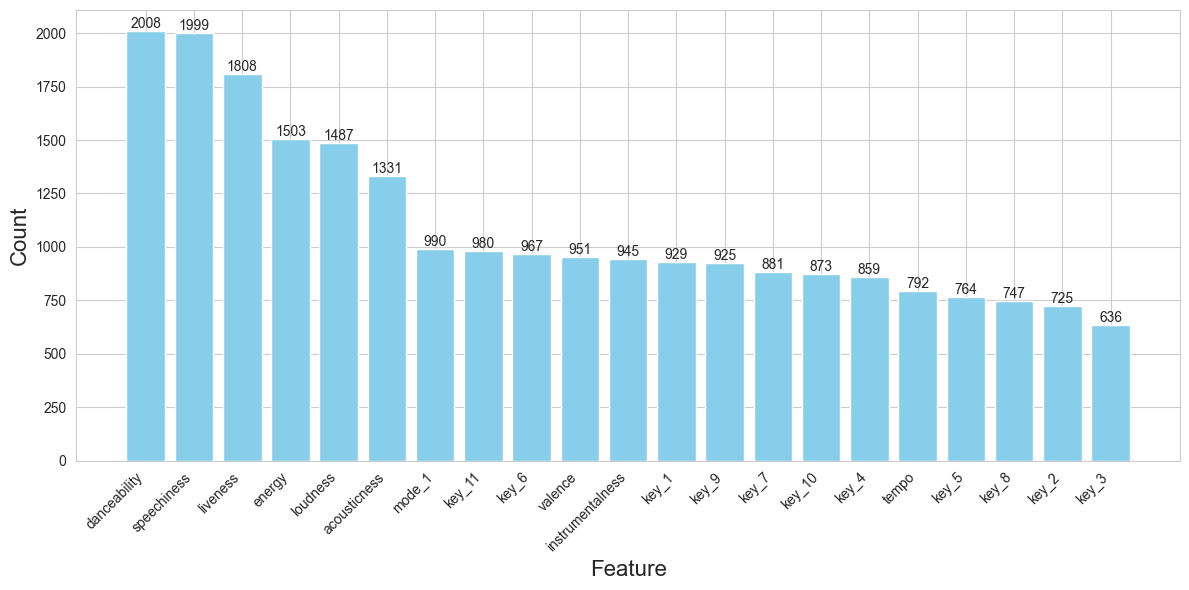

In [114]:
all_features = []
for feature in bestfeatures:
    for seed in bestfeatures[feature]:
        all_features.extend(bestfeatures[feature][seed])

feature_counts = Counter(all_features)

sorted_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)
features, counts = zip(*sorted_features)

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(features, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature', fontsize=16)
plt.ylabel('Count', fontsize=16)
for i, count in enumerate(counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')
plt.tight_layout()
plt.savefig('FeatureCount_all.eps', format='eps')
plt.show()

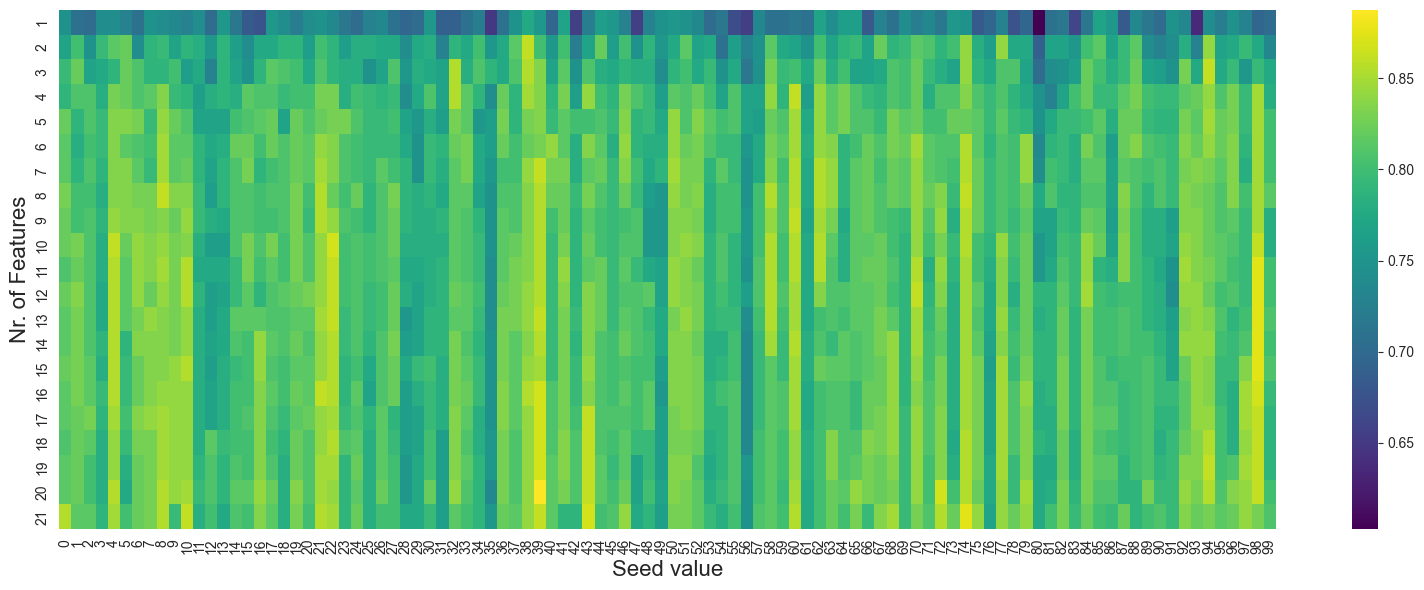

In [102]:
# default parameters
n_features = sorted(accuracy_orig_dict.keys())
seed_nrs = range(100)
Z = np.array([[accuracy_orig_dict[n_feature][seed_nr] for n_feature in n_features] for seed_nr in seed_nrs])

# Create a heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(Z.T, xticklabels=seed_nrs, yticklabels=n_features, cmap='viridis', annot=False)
plt.xlabel('Seed value', fontsize=16)
plt.ylabel('Nr. of Features', fontsize=16)
plt.tight_layout()
plt.savefig('AccuracyHeatmap_all.eps', format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


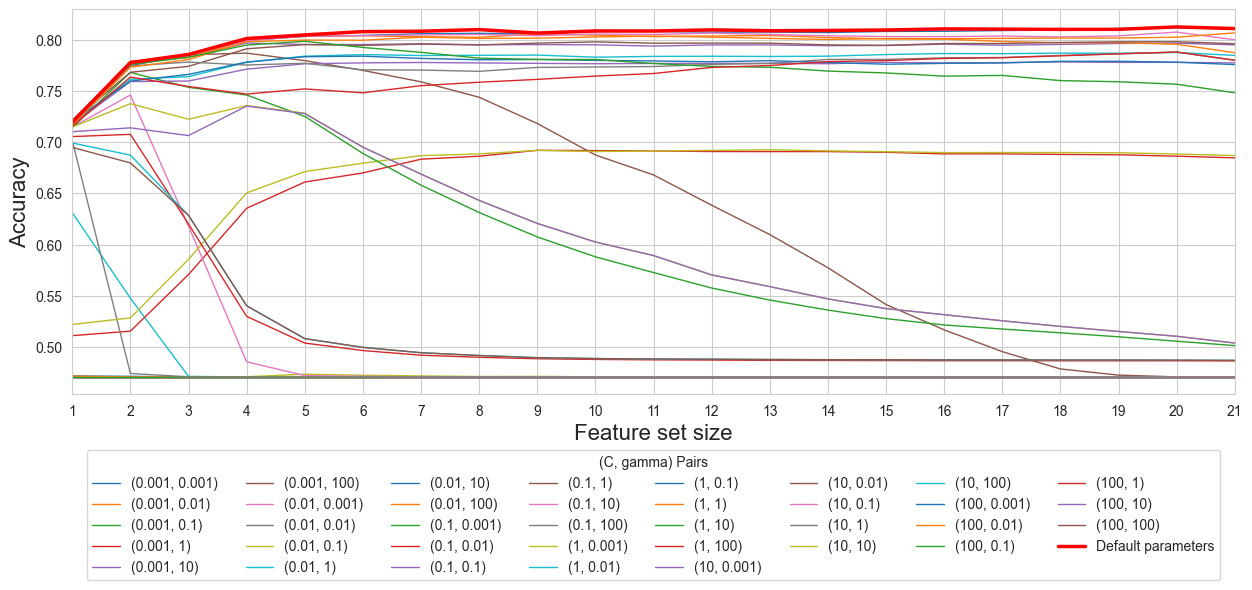

In [106]:
average_dict_orig = {key: sum(values.values()) / len(values) for key, values in accuracy_orig_dict.items()}
keys_orig = list(average_dict_orig.keys())    # Top-level keys (1 to 21)
values_orig = list(average_dict_orig.values())  # Corresponding average values

sum_dict_mod = {}

# Iterate through the dictionary to collect sums and counts
for i, val_i in accuracy_orig_dict.items():
    sum_dict_mod[i] = {}
    for seed, val_seed in accuracy_mod_dict[i].items():
        for k, val_k in accuracy_mod_dict[i][seed].items():
            if k not in sum_dict_mod[i]:
                sum_dict_mod[i][k] = {}
            for l, val_l in accuracy_mod_dict[i][seed][k].items():
                if l not in sum_dict_mod[i][k]:
                    sum_dict_mod[i][k][l] = 0
                value = accuracy_mod_dict[i][seed][k][l]
                sum_dict_mod[i][k][l] += value 

# Create the result dictionary for averages
average_dict_mod = {}
for i in sum_dict_mod:
    average_dict_mod[i] = {}
    for k in sum_dict_mod[i]:
        if k not in average_dict_mod[i]:
            average_dict_mod[i][k] = {}
        for l in sum_dict_mod[i][k]:
            average_dict_mod[i][k][l] = sum_dict_mod[i][k][l] / len(accuracy_mod_dict[i].items())

plt.figure(figsize=(15, 5))
for k in average_dict_mod[1]:  # Get k from the first i
        for l in average_dict_mod[1][k]:  # Get l from the first i
            # Prepare x and y data for plotting
            x = list(average_dict_mod.keys())
            #print(x)# i values (x-axis)
            y = [average_dict_mod[i][k][l] for i in x]  # corresponding y values
            #print(y)
            # Plotting
            plt.plot(x, y, label=f'({C_grid[k]}, {gamma_grid[l]})', linewidth=1)
plt.plot(keys_orig, values_orig, linewidth=2.5, color='red', label='Default parameters')
plt.xlabel('Feature set size', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(title='(C, gamma) Pairs', loc='lower center', ncol=8, bbox_to_anchor=(0.5, -0.5))
plt.grid(True)
plt.xlim(1,21)
plt.xticks(keys_orig)
plt.savefig('AccuracyHyperparameterVar.eps', format='eps')
plt.show()

Default hyperparameters are the best performing. Model performs well already at 4-6 features. Those 4-6 features are the following:

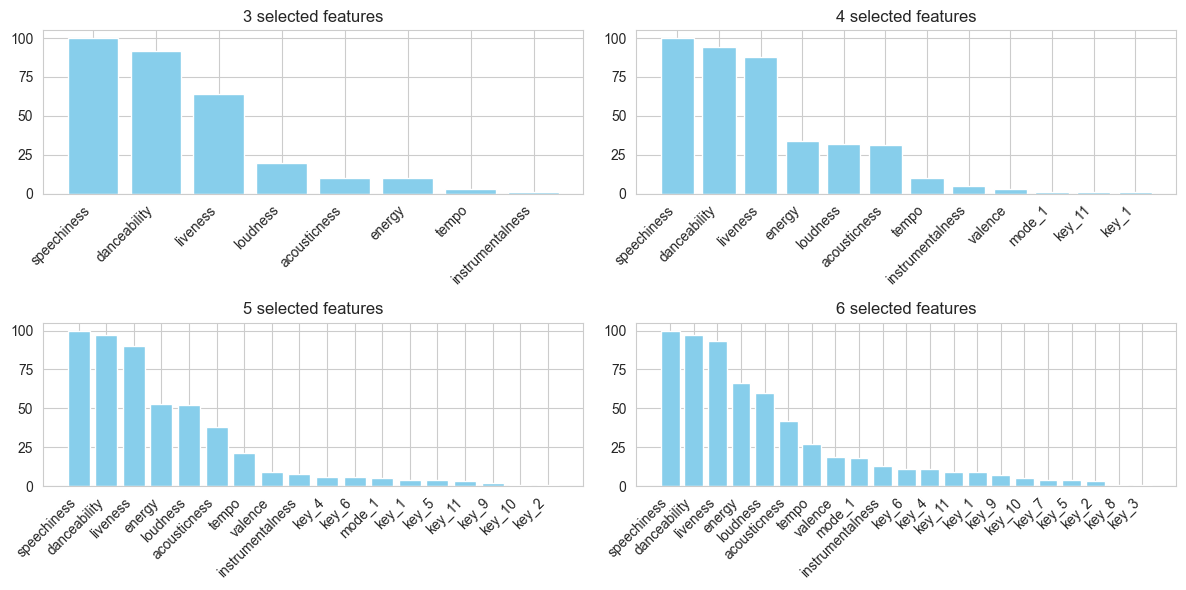

In [131]:
all_features_3 = []
all_features_4 = []
all_features_5 = []
all_features_6 = []

for seed in bestfeatures[4]:
    all_features_3.extend(bestfeatures[3][seed])
    all_features_4.extend(bestfeatures[4][seed])
    all_features_5.extend(bestfeatures[5][seed])
    all_features_6.extend(bestfeatures[6][seed])

feature_counts_3 = Counter(all_features_3)
feature_counts_4 = Counter(all_features_4)
feature_counts_5 = Counter(all_features_5)
feature_counts_6 = Counter(all_features_6)

sorted_categories_3 = sorted(feature_counts_3.items(), key=lambda x: x[1], reverse=True)
sorted_categories_4 = sorted(feature_counts_4.items(), key=lambda x: x[1], reverse=True)
sorted_categories_5 = sorted(feature_counts_5.items(), key=lambda x: x[1], reverse=True)
sorted_categories_6 = sorted(feature_counts_6.items(), key=lambda x: x[1], reverse=True)
categories_3, counts_3 = zip(*sorted_categories_3)
categories_4, counts_4 = zip(*sorted_categories_4)
categories_5, counts_5 = zip(*sorted_categories_5)
categories_6, counts_6 = zip(*sorted_categories_6)

# Create a bar plot
# Create bars for each feature
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

axs[0, 0].bar(categories_3, counts_3, color='skyblue')
axs[0, 0].set_title('3 selected features')
axs[0, 0].set_xticks(range(len(categories_3)))  # Set positions for ticks
axs[0, 0].set_xticklabels(categories_3, rotation=45, ha='right')

axs[0, 1].bar(categories_4, counts_4, color='skyblue')
axs[0, 1].set_title('4 selected features')
axs[0, 1].set_xticks(range(len(categories_4)))  # Set positions for ticks
axs[0, 1].set_xticklabels(categories_4, rotation=45, ha='right')

axs[1, 0].bar(categories_5, counts_5, color='skyblue')
axs[1, 0].set_title('5 selected features')
axs[1, 0].set_xticks(range(len(categories_5)))  # Set positions for ticks
axs[1, 0].set_xticklabels(categories_5, rotation=45, ha='right')

axs[1, 1].bar(categories_6, counts_6, color='skyblue')
axs[1, 1].set_title('6 selected features')
axs[1, 1].set_xticks(range(len(categories_6)))  # Set positions for ticks
axs[1, 1].set_xticklabels(categories_6, rotation=45, ha='right')

# plt.ylabel('Count', fontsize=16)
# for i, count in enumerate(counts):
#     plt.text(i, count + 0.1, str(count), ha='center', va='bottom')
plt.tight_layout()
plt.savefig('FeatureImportance_3456.eps', format='eps')
plt.show()

The more features we try to use, the more diverse the composition of different "best" feature sets are. This is another reason why using fewer features make more sense. I chose 4 features: speechiness, danceability, liveness, loudness

# <span style="color:red">Final model and performance evaluation</span>

In [132]:
final_features_1 = ['speechiness', 'danceability', 'liveness', 'energy']
final_features_2 = ['speechiness', 'danceability', 'liveness', 'loudness']
accuracy_final_dict_1 = {}
accuracy_final_dict_2 = {}
# getting an idea of accuracy:
for i in [10, 20, 30]:
    accuracy_final_dict_1[i] = {}
    accuracy_final_dict_2[i] = {}
    for seed in range(200):
        print(f'Training split: {i/100}, seed = {seed}')
        predictors_train_final_1, predictors_test_final_1, response_train_final_1, response_test_final_1 = train_test_split(encoded_data[final_features_1], response, test_size=i/100, random_state=seed)
        predictors_train_final_2, predictors_test_final_2, response_train_final_2, response_test_final_2 = train_test_split(encoded_data[final_features_2], response, test_size=i/100, random_state=seed)
        
        model_1, accuracy_1 = svm_model('rbf', predictors_train_final_1, response_train_final_1, predictors_test_final_1, response_test_final_1, metrics = 'None')
        model_2, accuracy_2 = svm_model('rbf', predictors_train_final_2, response_train_final_2, predictors_test_final_2, response_test_final_2, metrics = 'None')
        
        accuracy_final_dict_1[i][seed] = accuracy_1
        accuracy_final_dict_2[i][seed] = accuracy_2


Training split: 0.1, seed = 0
Training split: 0.1, seed = 1
Training split: 0.1, seed = 2
Training split: 0.1, seed = 3
Training split: 0.1, seed = 4
Training split: 0.1, seed = 5
Training split: 0.1, seed = 6
Training split: 0.1, seed = 7
Training split: 0.1, seed = 8
Training split: 0.1, seed = 9
Training split: 0.1, seed = 10
Training split: 0.1, seed = 11
Training split: 0.1, seed = 12
Training split: 0.1, seed = 13
Training split: 0.1, seed = 14
Training split: 0.1, seed = 15
Training split: 0.1, seed = 16
Training split: 0.1, seed = 17
Training split: 0.1, seed = 18
Training split: 0.1, seed = 19
Training split: 0.1, seed = 20
Training split: 0.1, seed = 21
Training split: 0.1, seed = 22
Training split: 0.1, seed = 23
Training split: 0.1, seed = 24
Training split: 0.1, seed = 25
Training split: 0.1, seed = 26
Training split: 0.1, seed = 27
Training split: 0.1, seed = 28
Training split: 0.1, seed = 29
Training split: 0.1, seed = 30
Training split: 0.1, seed = 31
Training split: 0.

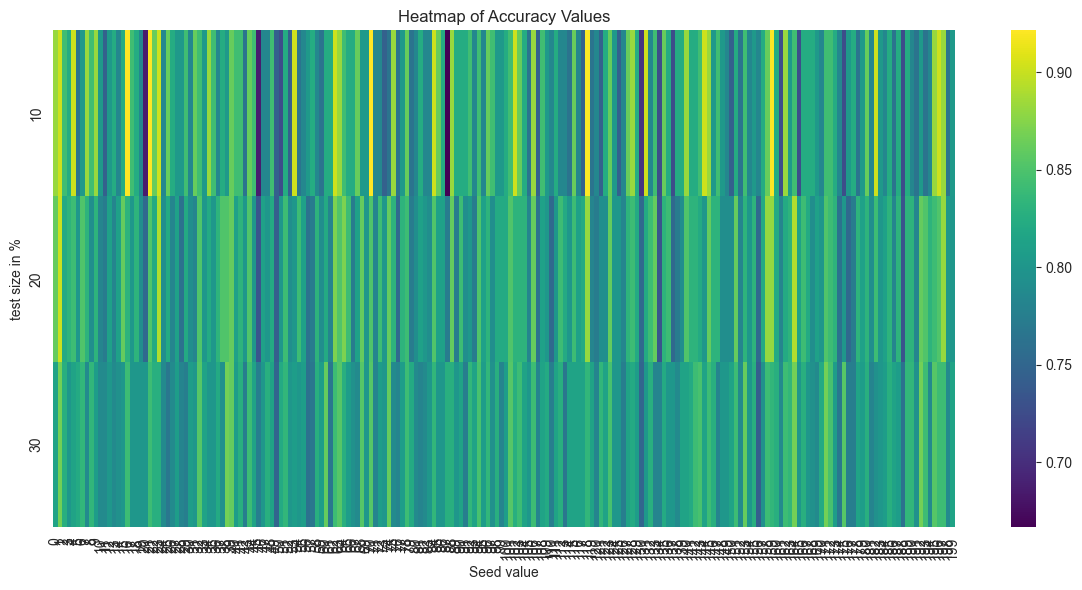

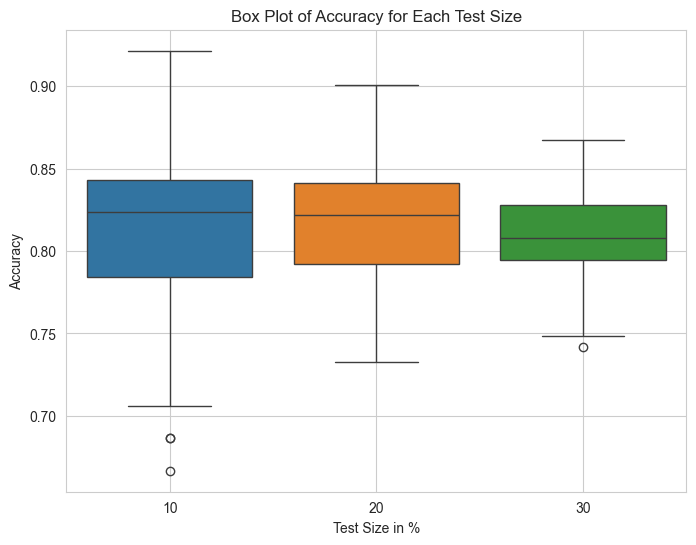

Max: 
 10    0.921569
20    0.900990
30    0.867550
dtype: float64
Min: 
 10    0.666667
20    0.732673
30    0.741722
dtype: float64
Mean: 
 10    0.816667
20    0.815891
30    0.811954
dtype: float64


In [137]:
splits = sorted(accuracy_final_dict_1.keys())
seed_nrs = range(200)
Z = np.array([[accuracy_final_dict_1[split][seed_nr] for split in splits] for seed_nr in seed_nrs])

# Create a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(Z.T, xticklabels=seed_nrs, yticklabels=splits, cmap='viridis', annot=False)
plt.xlabel('Seed value')
plt.ylabel('test size in %')
plt.title('Heatmap of Accuracy Values')
plt.tight_layout()
plt.savefig('Accuracy_heatmap_4_energy.eps', format='eps')
plt.show()

df = pd.DataFrame(accuracy_final_dict_1)
plt.figure(figsize=(8, 6))
sns.boxplot(data=df)
plt.title('Box Plot of Accuracy for Each Test Size')
plt.xlabel('Test Size in %')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('Boxplot_4_energy.eps', format='eps')
plt.show()

print(f'Max: \n {df.max()}')
print(f'Min: \n {df.min()}')
print(f'Mean: \n {df.mean()}')


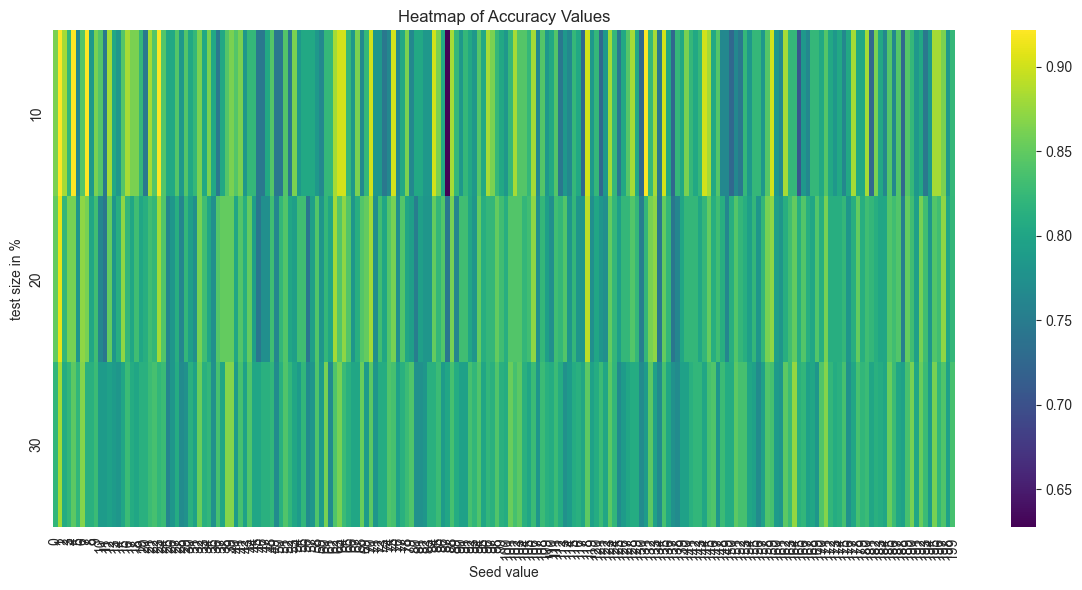

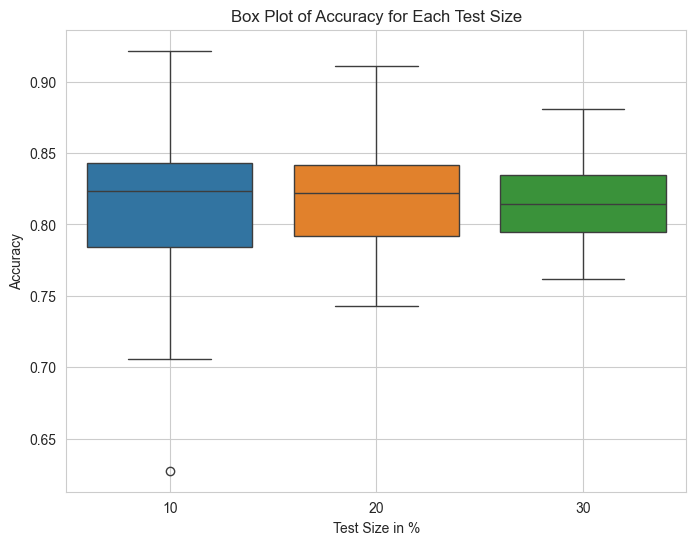

Max: 
 10    0.921569
20    0.910891
30    0.880795
dtype: float64
Min: 
 10    0.627451
20    0.742574
30    0.761589
dtype: float64
Mean: 
 10    0.816569
20    0.817228
30    0.813775
dtype: float64


In [138]:
splits = sorted(accuracy_final_dict_2.keys())
seed_nrs = range(200)
Z = np.array([[accuracy_final_dict_2[split][seed_nr] for split in splits] for seed_nr in seed_nrs])

# Create a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(Z.T, xticklabels=seed_nrs, yticklabels=splits, cmap='viridis', annot=False)
plt.xlabel('Seed value')
plt.ylabel('test size in %')
plt.title('Heatmap of Accuracy Values')
plt.tight_layout()
plt.savefig('Accuracy_heatmap_4_loudness.eps', format='eps')
plt.show()

df = pd.DataFrame(accuracy_final_dict_2)
plt.figure(figsize=(8, 6))
sns.boxplot(data=df)
plt.title('Box Plot of Accuracy for Each Test Size')
plt.xlabel('Test Size in %')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('Boxplot_4_loudness.eps', format='eps')
plt.show()

print(f'Max: \n {df.max()}')
print(f'Min: \n {df.min()}')
print(f'Mean: \n {df.mean()}')

Smaller test size with such small database is more prone to "lucky" and "unlucky" splits, thus both the max. and min. accuracy values are in the 10% bracket, and by seeing that the average accuracy drops by increasing the testing set size, we can infer that accuracy is very much dependent on the training set size.

In [139]:
# Saving the dictionaries into file:
import pickle

with open('accuracy_orig_dict.pkl', 'wb') as f:
    pickle.dump(accuracy_orig_dict, f)
    
with open('accuracy_mod_dict.pkl', 'wb') as f:
    pickle.dump(accuracy_mod_dict, f)

with open('bestfeatures.pkl', 'wb') as f:
    pickle.dump(bestfeatures, f)